In [1]:
import sys, os
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint
from rdkit import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

In [2]:
df1 = pd.read_csv('dataset/curated_binders/binders_from_chembl.csv')
df1.head(2)

,lig_chembl_id,pro_chembl_id,pref_name,accession,pchembl_value,standard_type,assay_id,confidence_score,canonical_smiles,description,HeavyAtomCount,NHOHCount,NOCount,LE
0,CHEMBL388978,CHEMBL2801,CaM kinase II delta,Q13557,10.51,IC50,1828461,9,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,Inhibition of human CAMK2D using KKLNRTLSFAEPG...,35,2,7,0.300286
1,CHEMBL4218769,CHEMBL2801,CaM kinase II delta,Q13557,10.30,IC50,1749582,9,CCN(CC)[C@@H](C)CNC(=O)c1cc(NC)nc(-c2cnn3ccc(-...,Inhibition of recombinant human full length Hi...,33,2,8,0.312121


In [3]:
df2 = pd.read_csv('dataset/curated_binders/binders_from_PubChem.csv')
df2.head(2)

,cid,activity,acname,acvalue,canonical_smiles,HeavyAtomCount,NHOHCount,NOCount,pValue,LE
0,451705,Active,Kd,0.000024,CC12C(C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=...,35,2,7,10.619789,0.303423
1,44259,Active,IC50,0.000031,CC12C(C(CC(O1)N3C4=CC=CC=C4C5=C6C(=C7C8=CC=CC=...,35,2,7,10.507240,0.300207


### Clustering molecules

In [4]:
mols = []
Name = []
label = []


for i,j,k in zip(df1['canonical_smiles'], df1['lig_chembl_id'], df1['pchembl_value']):
    mol = Chem.MolFromSmiles(i)
    mols.append(mol)
    Name.append(j)
    label.append('%s | pValue=%.2f'%(j,k))
    
for i,j,k in zip(df2['canonical_smiles'], df2['cid'], df2['pValue']):
    mol = Chem.MolFromSmiles(i)
    mols.append(mol)
    Name.append(j)
    label.append('cid%d | pValue=%.2f'%(j,k))

Calculate MorganFingerprint and based on it to calculate distance (1-tanimotoSimilarity)

In [5]:
fps = [GetMorganFingerprint(x,3) for x in mols]
nfps = len(fps)

In [6]:
def distij(i,j,fps=fps):
    return 1-DataStructs.TanimotoSimilarity(fps[i],fps[j])

Clustering use MaxMinPicker function in RDKit

In [7]:
picker = MaxMinPicker()
pickIndices = picker.LazyPick(distij,nfps,25,seed=10)

In [9]:
picks = [mols[x] for x in pickIndices]
picks_label = [label[x] for x in pickIndices]
picks_name = [Name[x] for x in pickIndices]

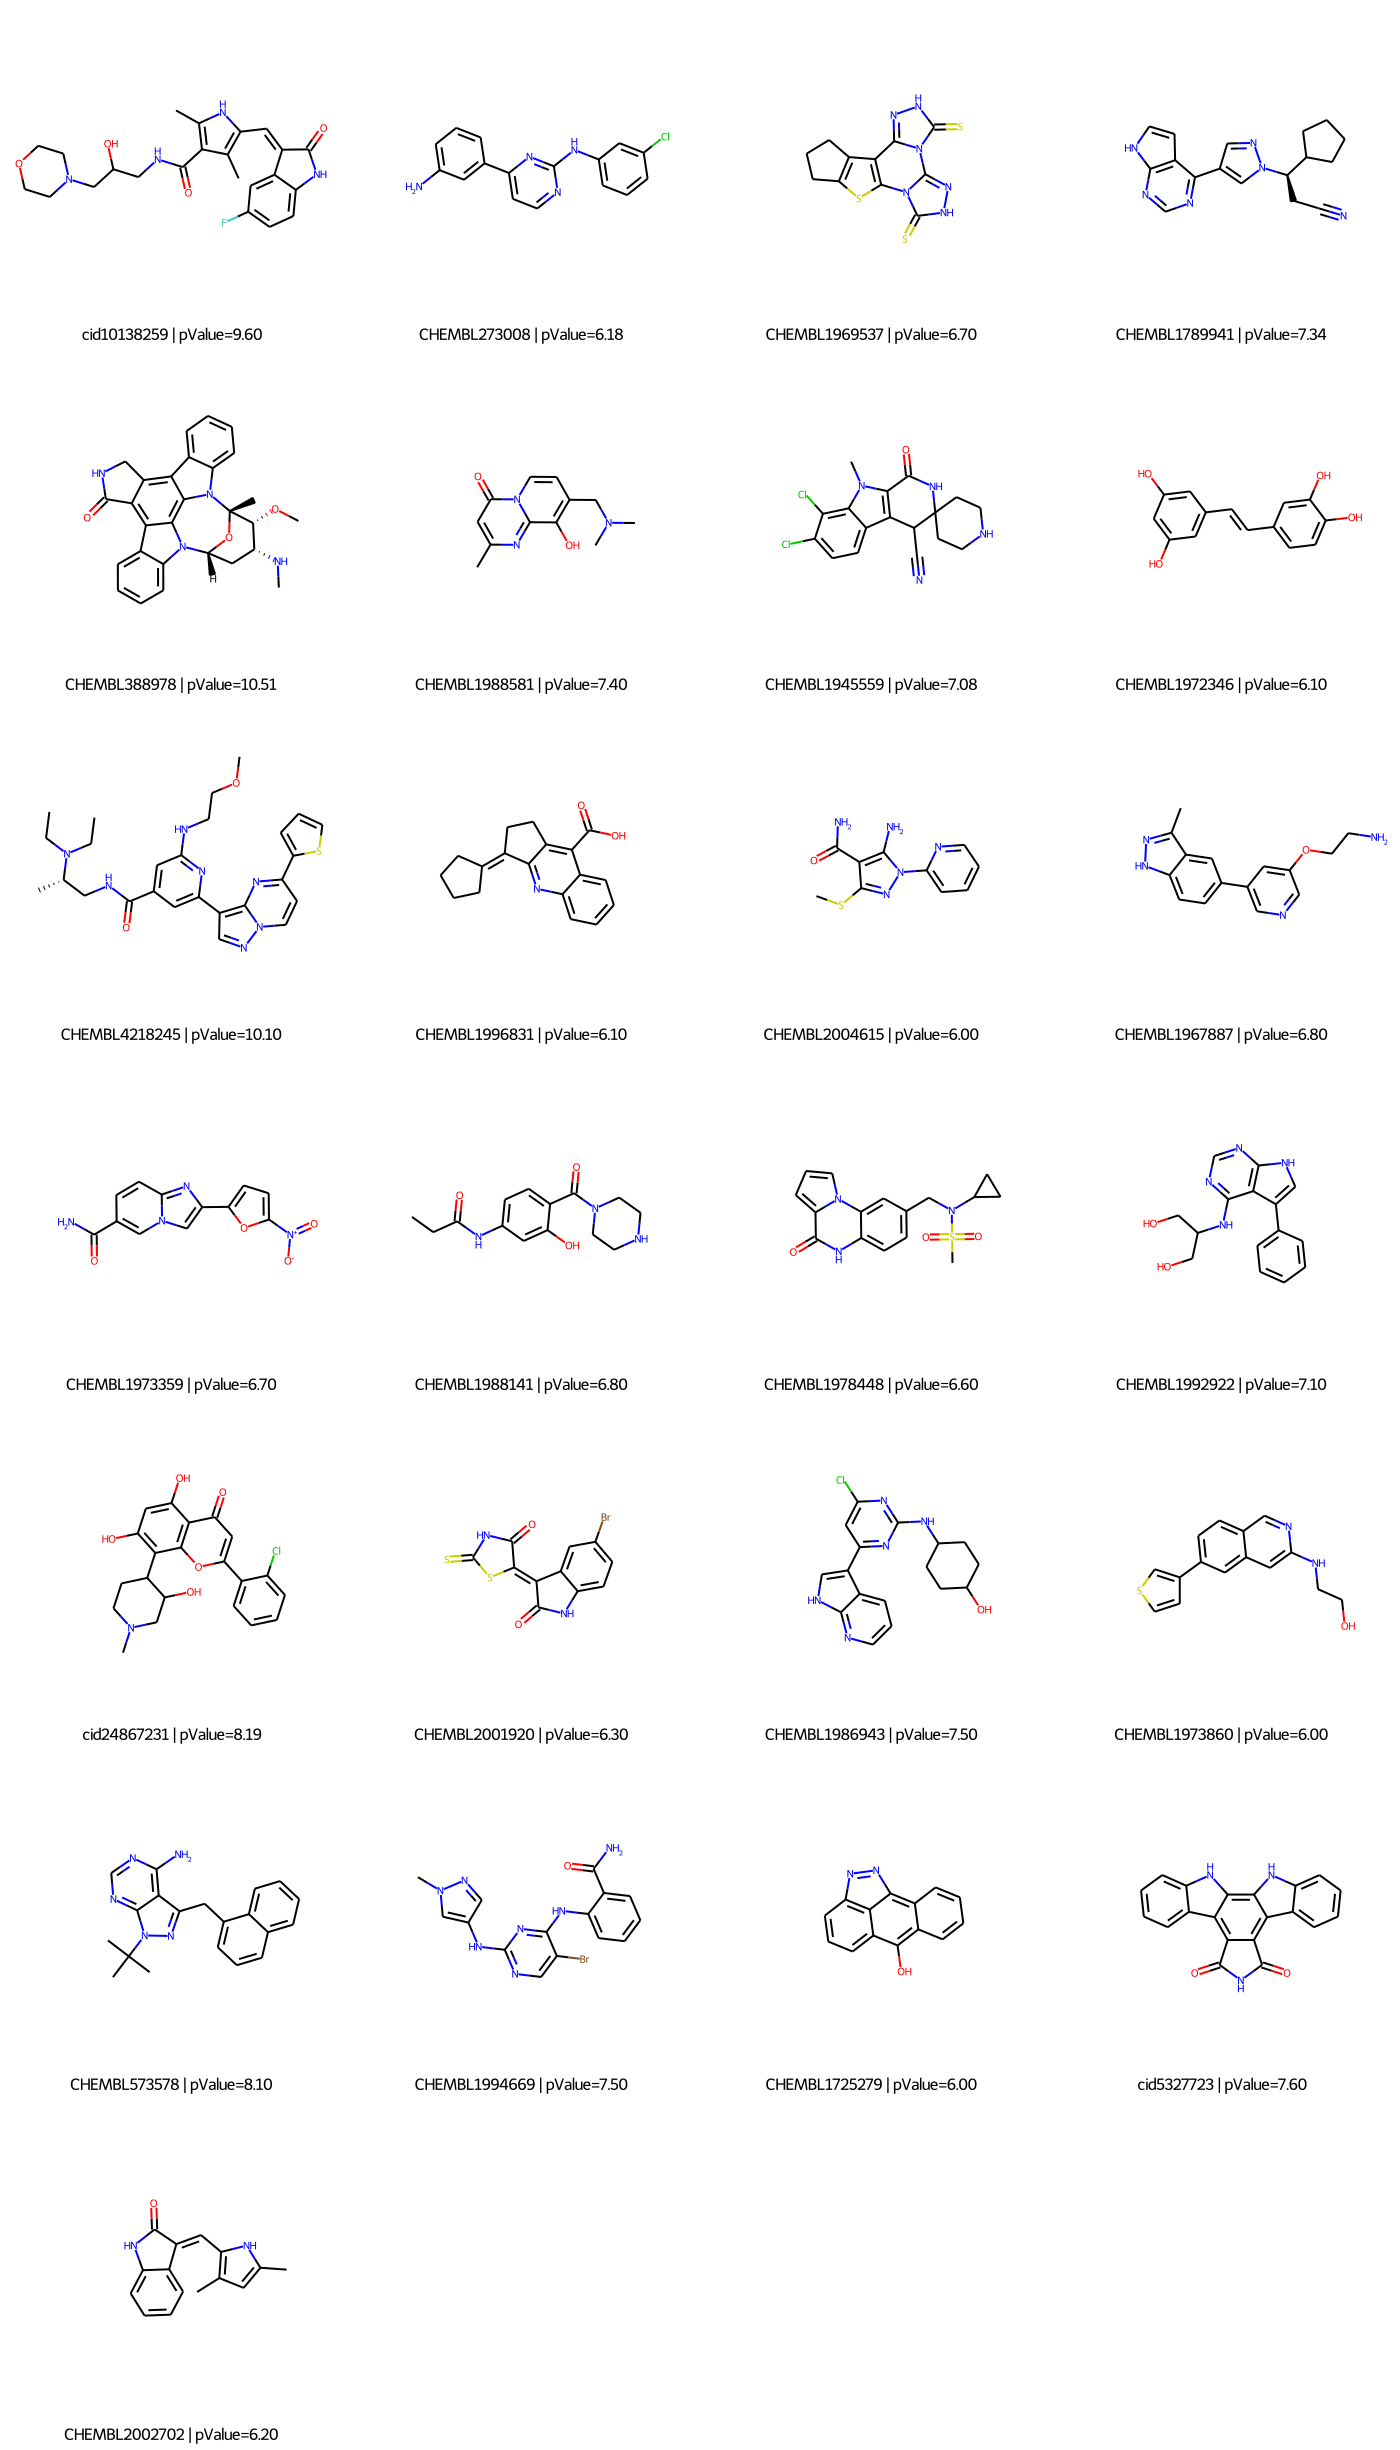

In [10]:
Chem.Draw.MolsToGridImage(picks,molsPerRow=4,subImgSize=(350, 350), legends=picks_label)

In [11]:
def Merge_to_data(mols,labels):
    SMILES = [Chem.MolToSmiles(x) for x in mols]
    df = pd.DataFrame(list(zip(SMILES,labels)), columns=['smiles','label'])
    df['ligand_id'] = pd.Series(range(1, len(df)+1), index=df.index)
    return df

In [12]:
df = Merge_to_data(picks, picks_label)

In [13]:
df.to_csv('dataset/curated_binders/binders_after_cluster.csv', index=False)